# Mapping Hurricanes and Storms with AWS-Hosted NEXRAD Level II Reflectivity

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pyart
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import boto3
import botocore
from botocore.client import Config
from PIL import Image


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Sources
- [Plotting AWS-hosted NEXRAD Level 2 Data
](https://unidata.github.io/python-gallery/examples/Nexrad_S3_Demo.html)
- [Reading Older NEXRAD Data and Fixing Latitude and Longitude Issues](https://arm-doe.github.io/pyart/examples/io/plot_older_nexrad_data_aws.html)
- [Reading NEXRAD Data from the AWS Cloud with Py-ART](https://arm-doe.github.io/pyart/examples/io/plot_nexrad_data_aws.html)
- [Drawing and Labelling Parallels and Meridians with Basemap](https://matplotlib.org/basemap/stable/users/graticule.html)

## Define Functions

In [2]:
def get_aws_file(station, date, time):
    """
    Gets the name of the radar data from NEXRAD AWS archive at a specific date and time
    input:
        station: string with 4 letters for NEXRAD Station (e.g., KTLX)
        date: string of format YYYYMMDD
        time: string of format HHMMSS (MM and SS are optional)
    """
    year, month, day = date[0:4], date[4:6], date[6:8]
    hour = time[0:2]
    if len(time) == 2:
        min = ''
        sec = ''
    elif len(time) == 4:
        min = time[2:4]
        sec = ''
    elif len(time) == 6:
        min = time[2:4]
        sec = time[4:6]
    else:
        print(f'Unable to read time of {time}')

    # Get full AWS path to the radar data at input date and time
    s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
    bucket = s3.Bucket('noaa-nexrad-level2')
    bucket_files = bucket.meta.client.list_objects(Bucket='noaa-nexrad-level2', Prefix=f'{year}/{month}/{day}/{station}/{station}{year}{month}{day}_{hour}{min}{sec}', Delimiter='/')

    if 'Contents' in bucket_files:
        # Get the first filename that matches the input
        content = bucket_files['Contents'][0]
        radar_file = content['Key']
        print("NEXRAD AWS radar file:", radar_file)
    else:
        raise Exception('No data found in NEXRAD AWS archive for input date and time.')
    
    # Create title and filename for map, to be used in plot_nexrad_z_one() function
    title = f"{station} | {datetime.strptime(date, '%Y%m%d').strftime('%B %d, %Y')} | {hour} UTC"
    filename = f'{station}/{station}_{date}_{hour}'

    return radar_file, title, filename

def plot_nexrad_z_one(radar_file, title, filename, width=9, height=7, save=True):
    """
    Creates plot of NEXRAD WSR-88D radar reflectivity data
    input:
        radar_file: name of radar file from NEXRAD AWS archive
        title: of the format '{station}, {year}-{month}-{day} {hour}:{minute} UTC'
            radar_file and title are from get_aws_file() function
        width: the longitude degrees of the image
        height: the latitude degrees of the image
        save: True to save image as a PNG, False to only plot within notebook
    """
    aws_file = (f"s3://noaa-nexrad-level2/{radar_file}")
    radar = pyart.io.read_nexrad_archive(aws_file, station=radar_file.split('/')[3])

    # Read radar file
    display = pyart.graph.RadarMapDisplayBasemap(radar)
    
    center_lat = round(radar.latitude["data"][0])
    center_lon = round(radar.longitude["data"][0])
    
    # Create basemap with Stereographic projection
    m = Basemap(projection = 'stere',
                llcrnrlat = center_lat - height/2, urcrnrlat = center_lat + height/2,
                llcrnrlon = center_lon - width/2, urcrnrlon = center_lon + width/2,
                resolution = 'i',
                lat_0 = center_lat, lon_0 = center_lon)
    
    fig, ax = plt.subplots(figsize=(12, 8))

    m.drawcoastlines(linewidth=0.25, color="#474747")
    m.drawstates(linewidth=0.25, color="#474747")
    m.fillcontinents(color='#ebebeb')

    # Draw parallels
    parallels = np.arange(round(center_lat - height), round(center_lat + height), 2)
    m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10, color="#ebebeb", linewidth=0.25)
    # Draw meridians
    meridians = np.arange(round(center_lon - width), round(center_lon + width), 2)
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, color="#ebebeb", linewidth=0.25)

    display.plot_ppi_map(
        "reflectivity",
        title="",
        sweep=0,
        projection='stere',
        cmap='pyart_HomeyerRainbow',
        colorbar_orient='vertical',
        colorbar_label="Reflectivity $Z$ (dBZ)",
        ticks=[-20, -10, 0, 10, 20, 30, 40, 50, 60],
        ticklabs=['≤ –20', '–10', '0', '10', '20', '30', '40', '50', '≥ 60'],
        vmin=-20,
        vmax=60,
        embellish=False,
        basemap=m
    )

    plt.title(title, loc='left', fontsize=16)
    plt.title("Reflectivity $Z$ (dBZ)", loc='right', fontsize=16)

    plt.tight_layout()
    filepath = f"{filename}.png"

    if save:
        # Export figure as PNG
        plt.savefig(filepath, dpi=300, format='png', bbox_inches='tight')

    return fig, filepath

def plot_nexrad_z_range(station, start_time, end_time, custom_title=False, name=None):
    """
    Downloads maps of plots from start_time to end_time (inclusive)
    input:
        station: 4 letters like KTLX
        start_date: format 'YYYYMMDD HH'
        end_date: format 'YYYYMMDD HH'
    """
    # Initialize list of filenames to make GIF
    filepaths = []

    # Get hourly increments between given dates and times
    times = [time.strftime('%Y%m%d %H').split(' ') for time in pd.date_range(start_time, end_time, freq='h')]
    for date, hour in times:
        try:
            radar_file, title, filename = get_aws_file(station, date, hour)
            if (custom_title == True) & (name is not None):
                plot_title = f'{name} | {datetime.strptime(date, '%Y%m%d').strftime('%B %d, %Y')} | {hour} UTC'
            else:
                plot_title = title
            fig, filepath = plot_nexrad_z_one(radar_file, plot_title, filename, width=9, height=7, save=True)
            plt.close(fig)
            filepaths.append(filepath)
        except:
            print('No data found in NEXRAD AWS archive for input date and time.')
    
    return filepaths

def make_gif(output, image_paths, seconds):
    """
    Downloads a GIF timelapse
    input:
        output: path where GIF should be saved, ending in .gif
        image_paths: list of paths to images
        seconds: length of final GIF in seconds
    """
    all_images = [Image.open(img) for img in image_paths]

    # Create GIF that loops
    all_images[0].save(output, format='gif', append_images=all_images[1:], save_all=True, duration=seconds*1000/len(image_paths), loop=0)

## Create Maps

NEXRAD AWS radar file: 2021/08/29/KLIX/KLIX20210829_160636_V06


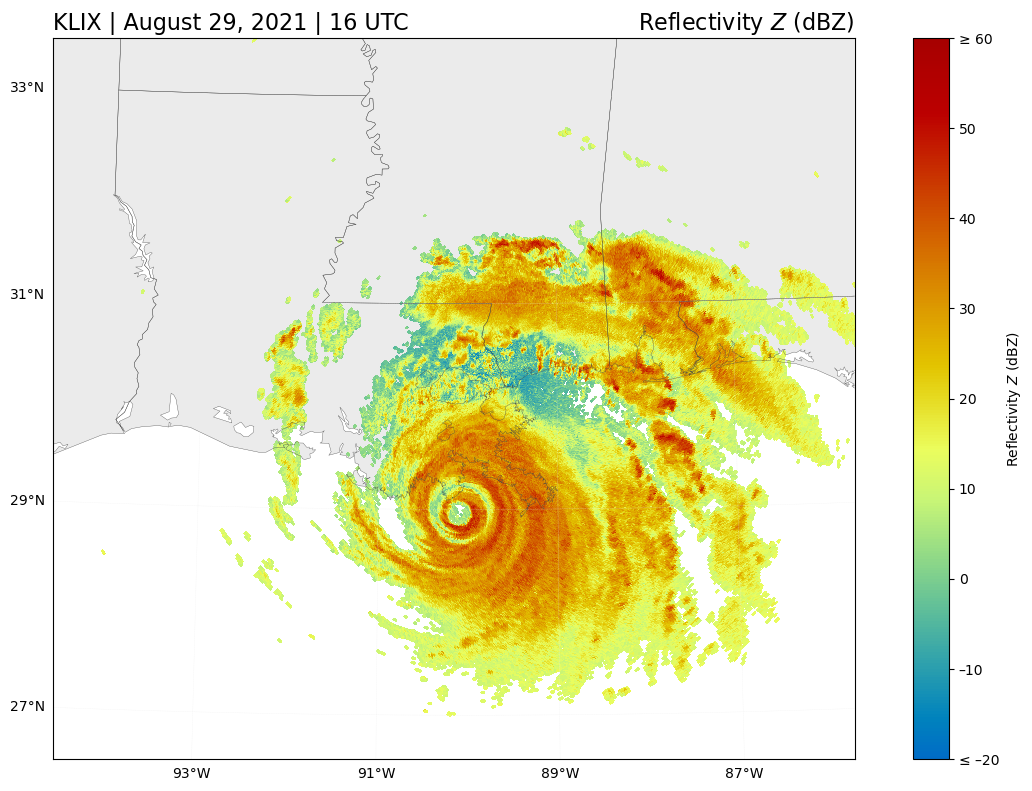

In [3]:
# Create a single map of Hurricane Ida reflectivity
radar_file, title, filename = get_aws_file('KLIX', '20210829', '16')
fig = plot_nexrad_z_one(radar_file, title, filename, save=False)

NEXRAD AWS radar file: 2005/08/29/KLIX/KLIX20050829_120034.gz


c:\Users\szhan\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\ai\Lib\site-packages\pyart\io\nexrad_archive.py:231: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] for moment REF.
  warnings.warn(


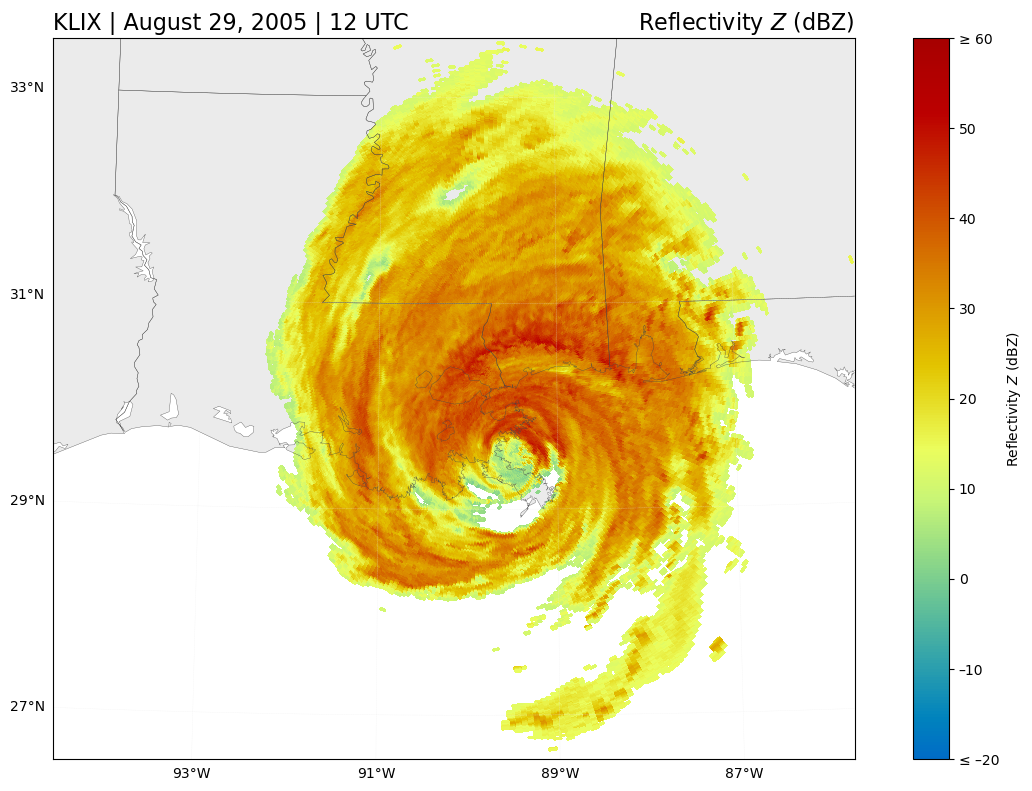

In [3]:
# Create a single map of Hurricane Katrina reflectivity
radar_file, title, filename = get_aws_file('KLIX', '20050829', '12')
fig = plot_nexrad_z_one(radar_file, title, filename, save=False)

# Note: Reading older NEXRAD data produces a UserWarning ('Gate spacing is not constant, interpolating data in scans ...')

NEXRAD AWS radar file: 2024/08/01/KAMX/KAMX20240801_100355_V06


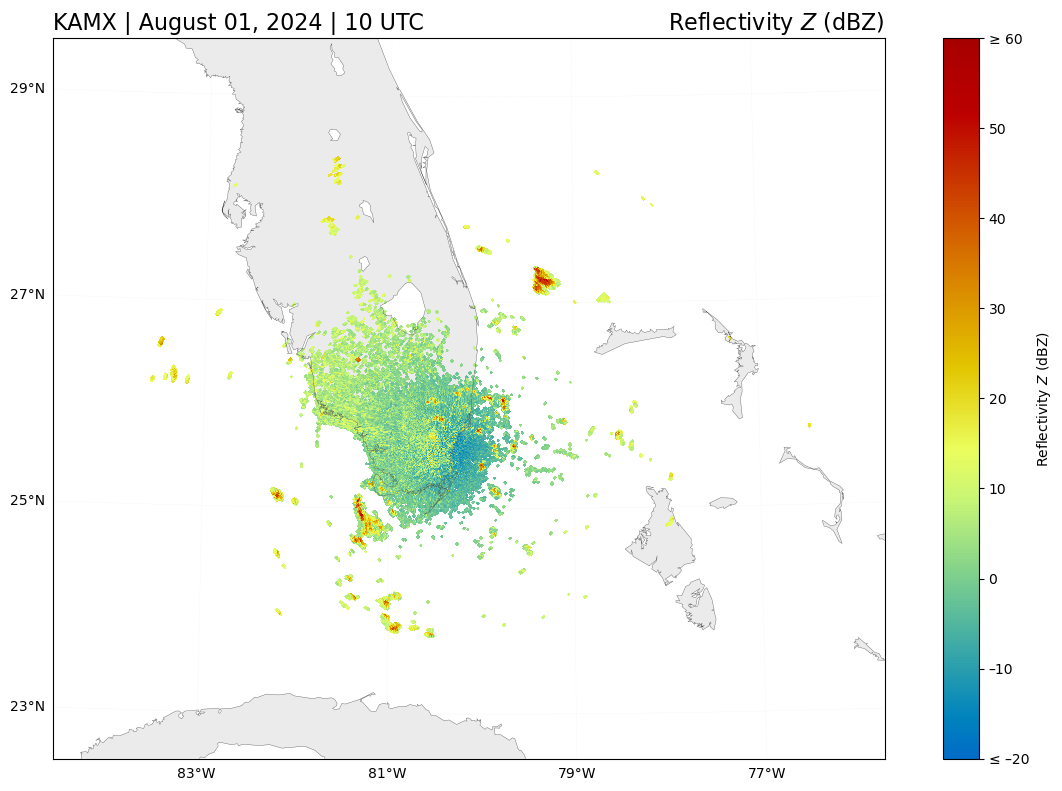

In [5]:
# Create a single map of South Florida reflectivity
radar_file, title, filename = get_aws_file('KAMX', '20240801', '10')
fig = plot_nexrad_z_one(radar_file, title, filename, save=False)

NEXRAD AWS radar file: 2024/08/18/KOKX/KOKX20240818_100411_V06


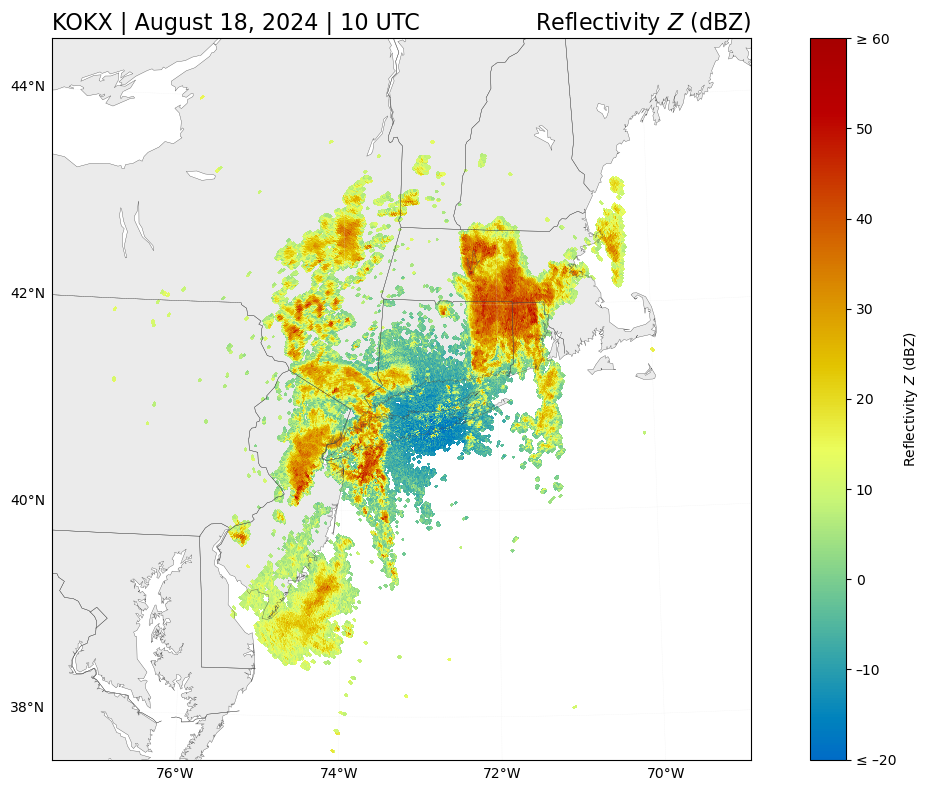

In [6]:
# Create a single map of New York reflectivity
radar_file, title, filename = get_aws_file('KOKX', '20240818', '10')
fig = plot_nexrad_z_one(radar_file, title, filename, save=False)

## Create Timelapse

In [ ]:
# Download files for each hour for Hurricane Ida
filepaths = plot_nexrad_z_range('KLIX', '20210829 01', '20210830 04', custom_title=True, name='Hurricane Ida')

make_gif('timelapse/klix_202108_nexrad_reflectivity_timelapse.gif', filepaths, 10)

In [ ]:
# Download files for each hour for Hurricane Katrina
filepaths = plot_nexrad_z_range('KLIX', '20050828 15', '20050829 13', custom_title=True, name='Hurricane Katrina')

# Note: Reading older NEXRAD data produces a UserWarning ('Gate spacing is not constant, interpolating data in scans ...')
make_gif('timelapse/klix_200508_nexrad_reflectivity_timelapse.gif', filepaths, 10)